### Q5 Handwritten digits 

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.cluster import KMeans
from numpy.linalg import norm as norm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

In [2]:
from tensorflow.contrib.learn.python.learn.datasets.mnist import extract_images, extract_labels
with open('train-images-idx3-ubyte', 'rb') as f:
  train_images = extract_images(f)
with open('train-labels-idx1-ubyte', 'rb') as f:
  train_labels = extract_labels(f)

Instructions for updating:
Please use tf.data to implement this functionality.
Extracting train-images-idx3-ubyte
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting train-labels-idx1-ubyte


In [3]:
x = train_images.reshape(60000, 28*28)[0:10000]/255
y = train_labels.reshape(60000,1)[0:10000]
y = [y[i][0] for i in range(len(y))]
y = np.array(y)

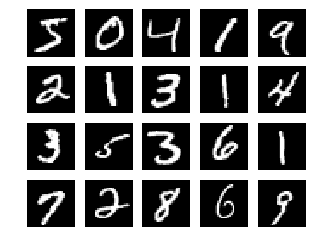

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
def display(data, nrows, ncols):
    plt.figure(figsize=(ncols*1, nrows*1))
    for i in range(nrows*ncols):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(data[i].reshape((28,28)), cmap='gray')
        plt.axis('off')
    plt.axis('off')
    plt.show()
display(x, 4, 5)

In [5]:
### PCA 
## (a) Extract principal components
# split data 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=0)
x_dev, x_test, y_dev, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=0)

In [6]:
# demean and compute svd
u, s, v = np.linalg.svd(x_train - np.mean(x_train, axis=0), full_matrices=False)

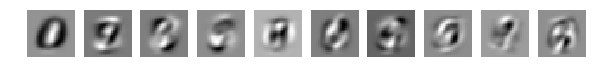

In [7]:
# first 10 principal components as images
display(v[:10, :], 1, 10)

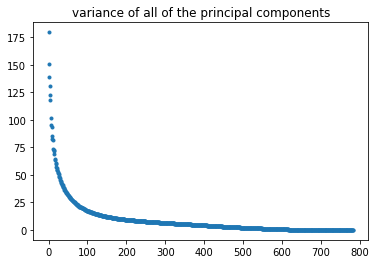

In [8]:
# plot variance
plt.scatter(range(len(s)), s, marker = '.')
plt.title(r'variance of all of the principal components')
plt.show()

In [9]:
## Dimension reduction
# project test data onto the first m principal components
# display(np.dot(np.dot(x_train, v[:10, :].T), v[:10, :]) + np.mean(x_train, axis=0), 4,5)
def predict_pca(m, data):
    # demean   
    mean = np.mean(data, axis=0)
    u, s, v = np.linalg.svd(data - mean, full_matrices=False)
    proj = np.dot(data - mean, v[:m, :].T)
    pca_inv = np.dot(proj, v[:m, :]) + mean
    display(pca_inv, 2, 10)  

original figures


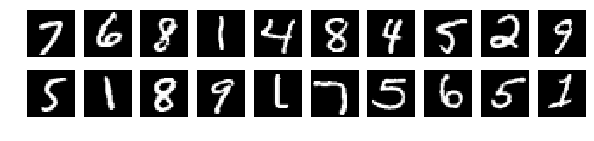

m = 10


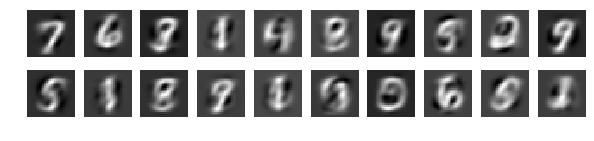

m = 100


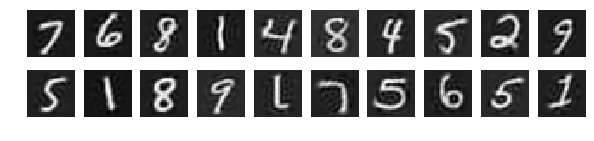

m = 200


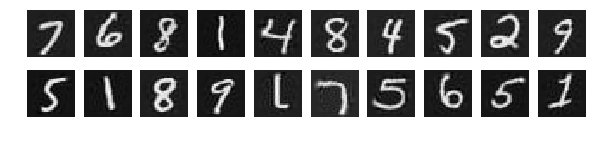

m = 700


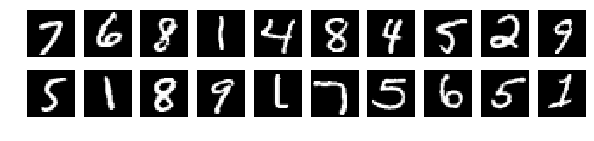

In [10]:
# experiment with m
print('original figures')
display(x_train, 2, 10)
print('m = 10')
predict_pca(10, x_train)
print('m = 100')
predict_pca(100, x_train)
print('m = 200')
predict_pca(200, x_train)
print('m = 700')
predict_pca(700, x_train)

original figures


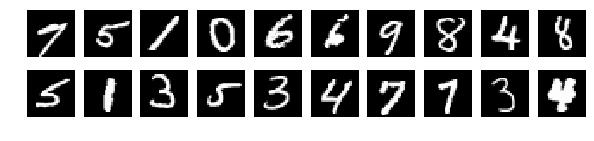

m = 100


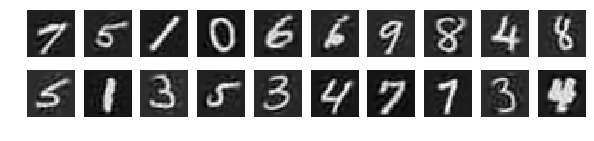

In [11]:
# experiment with different x
import random
ind = random.sample(range(10000), 6000)
print('original figures')
display(x[ind], 2, 10)
print('m = 100')
predict_pca(100, x[ind,:])

It can be seen that as the number of principal components increases, the figure becomes more clear. When m=10, the figures are hard to identify by eye balls. The top principal components represent the overall shape of these figures, but do not present details.

In [12]:
## Part 2: k-means
def kmeans_func(cl, x_tr, y_tr, x_orig):
    kmeans = KMeans(n_clusters=cl, random_state=0).fit(x_tr)
    y_pred = np.zeros(x_tr.shape[0])
    y = kmeans.labels_
    df_pred = pd.DataFrame({'y': y})
    df = pd.DataFrame(y_tr, columns = ['y'])
    for i in range(cl):
        ind = df_pred[df_pred['y'] == i].index
        #print(r'class:', len(ind))
        label = stats.mode(df.iloc[ind, :]['y']).mode[0]
        x = x_orig[ind[:10]]
        display(x, 1, 10)        
        # reclassify 
        for j in ind:            
            y_pred[j] = int(label)
    return y_pred

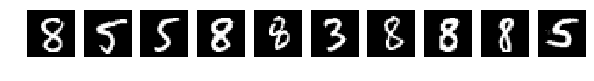

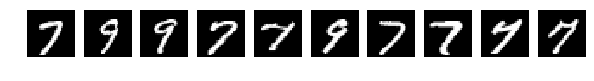

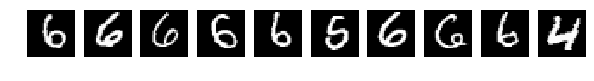

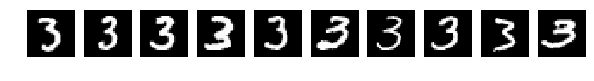

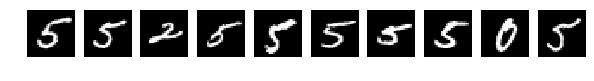

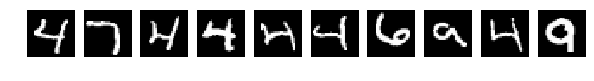

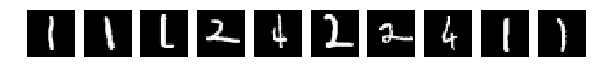

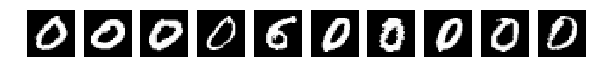

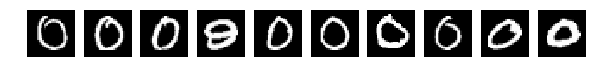

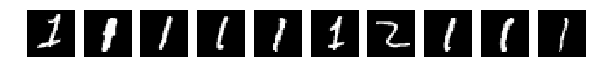

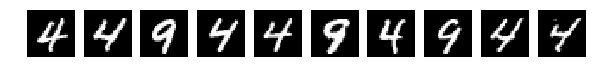

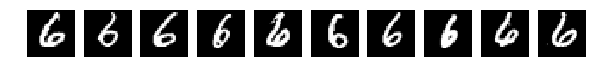

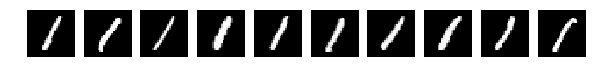

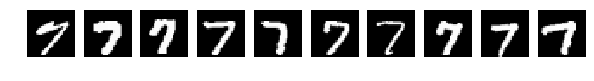

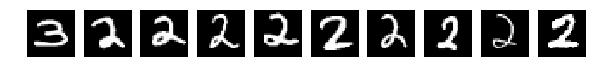

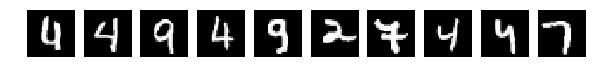

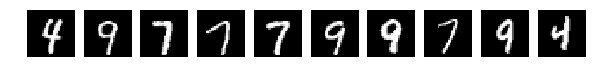

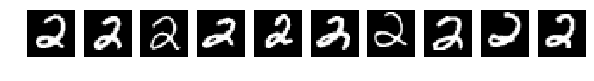

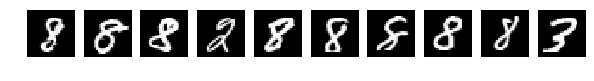

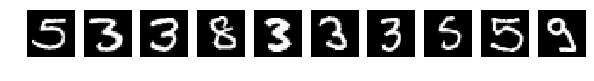

In [13]:
a = kmeans_func(20, x_train, y_train, x_train)

In [14]:
print('error rate: ', np.mean(a != y_train).round(4))

error rate:  0.2868


If we classify these images into 20 classes and 6000 points to train the model, it can be seen that the majority of these classes consist of the same figures or figures that resemble each other. For example, the third class consits of all three's and the twelfth class is all one's. However, it seems that this model cannot distinguish pairs like (7,9), (4,9), (3,5), (3,8) and (5,8). In order to determine how well this model predicts respect to their true labels, I calculate the error rate. The error rate is 28.68%. It is still quite high. 

In [15]:
## Part 3: Spectral clustering
def weight(data, h):
    n = data.shape[0]
    W = np.ones((n, n))
    for i in range(n):
        for j in range(i+1, n):
            w_ij = np.exp(- norm(data[i, :] - data[j, :])**2/h)
            W[i,j] = w_ij
            W[j,i] = w_ij
    return W

In [16]:
W = weight(x_train, 20)

In [17]:
def compute_lap(W):
    n = W.shape[0]
    D_t = np.diag(np.sum(W, axis = 1)**(-0.5))
    L = np.eye(n) - np.dot(np.dot(D_t, W), D_t)
    return L

In [18]:
L = compute_lap(W)

In [19]:
# Compute the bottom few eigenvectors of L
w, vec = np.linalg.eig(L)
r2 = vec[:, np.argsort(w)[1:3]]
r3 = vec[:, np.argsort(w)[1:4]]

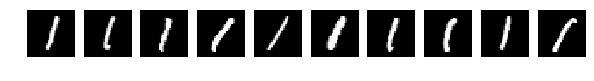

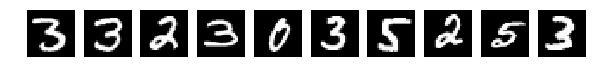

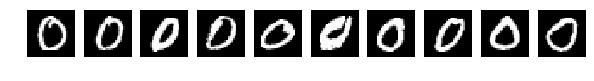

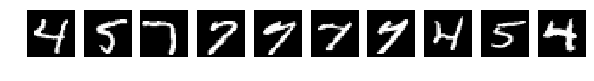

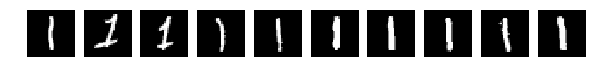

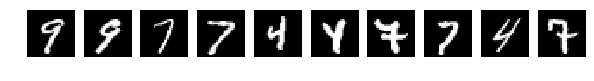

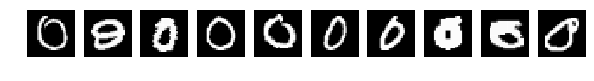

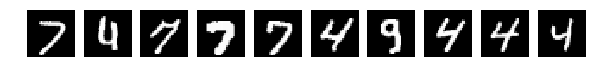

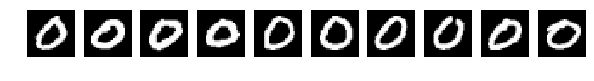

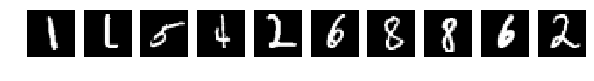

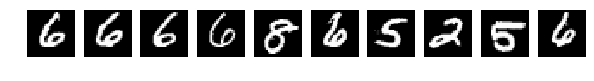

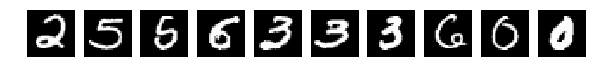

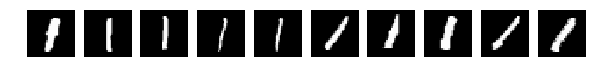

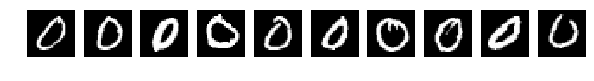

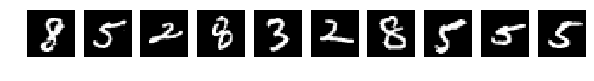

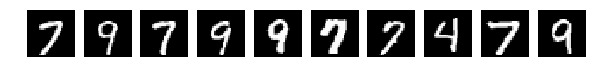

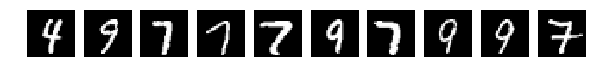

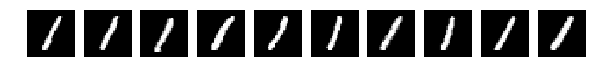

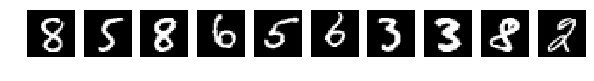

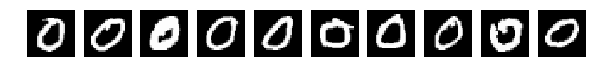

In [20]:
err2 = kmeans_func(20, r2, y_train, x_train)

In [21]:
print('error rate for r=2: ', np.mean(err2 != y_train).round(4))

error rate for r=2:  0.5407


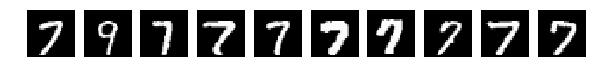

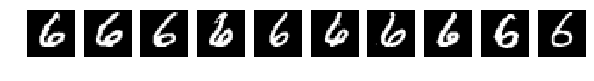

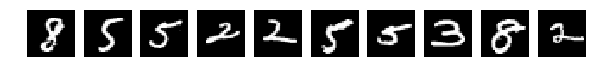

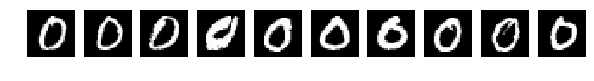

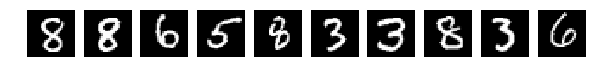

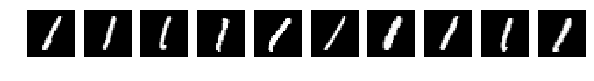

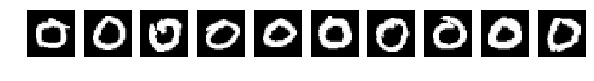

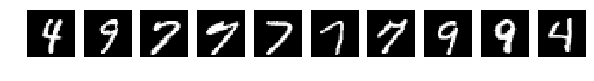

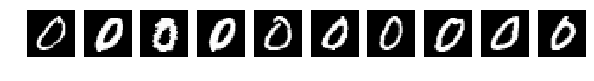

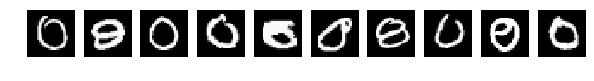

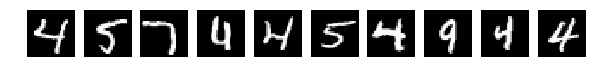

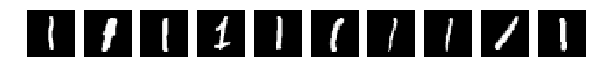

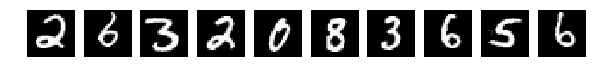

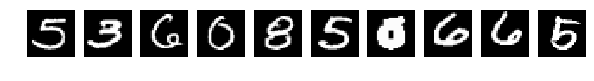

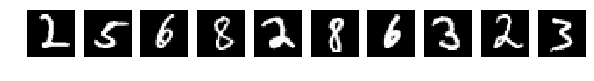

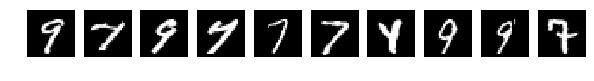

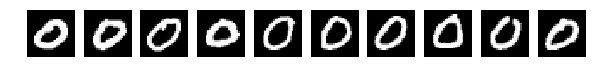

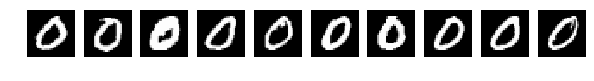

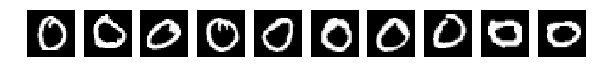

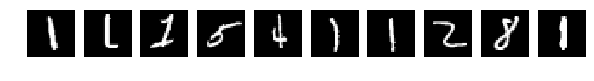

In [22]:
err3 = kmeans_func(20, r3, y_train, x_train)

In [23]:
print('error rate for r=3: ', np.mean(err3 != y_train).round(4))

error rate for r=3:  0.4837


For both r=2 and r=3, the error rate for labeling is 54.07% and 48.37% respectively, which are higher than the standard kmeans clustering. 

In [24]:
# select the appropriate bandwidth 
def select_bandwidth(data_x, data_y, h):
    W = weight(data_x, h)
    L = compute_lap(W)
    w, vec = np.linalg.eig(L)
    r3 = vec[:, np.argsort(w)[1:4]]
    err3 = kmeans_func(20, r3, data_y, x_train)    
    return np.mean(err3 != y_train).round(4)

25


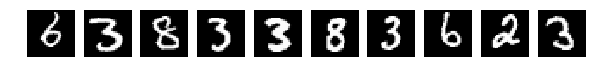

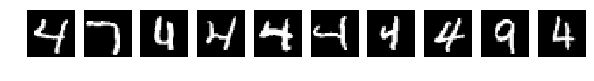

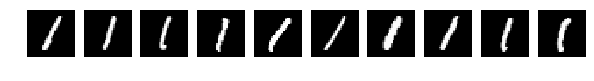

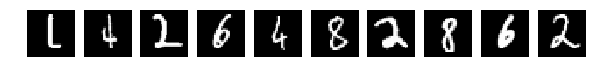

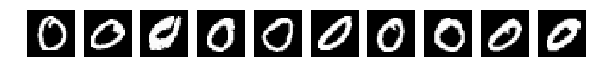

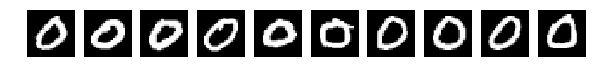

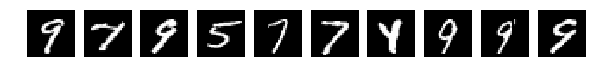

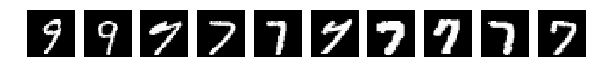

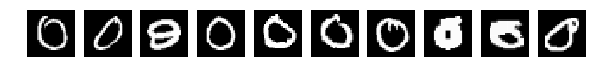

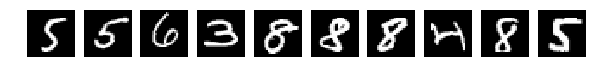

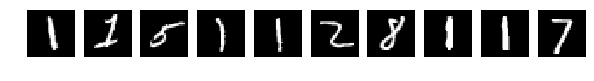

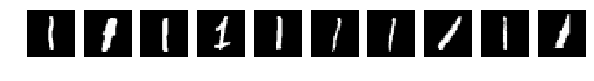

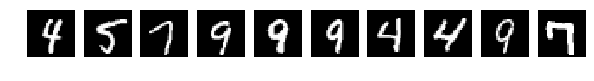

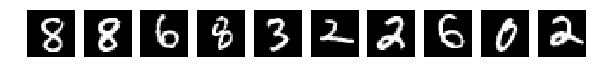

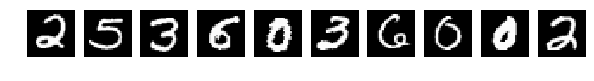

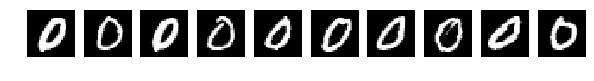

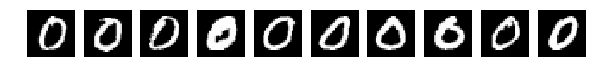

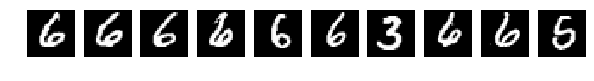

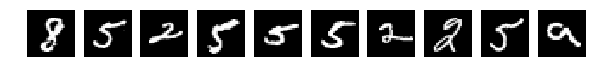

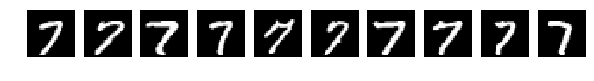

error rate for h = 25, :  0.476
30


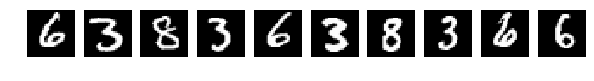

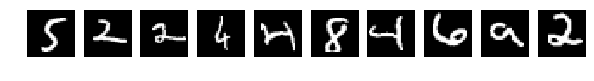

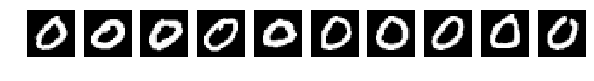

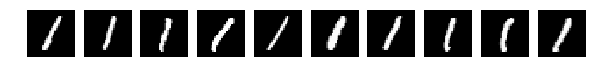

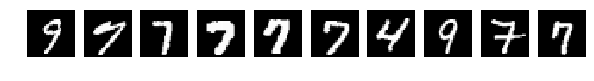

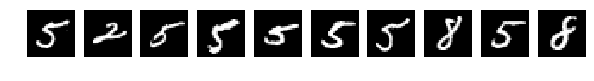

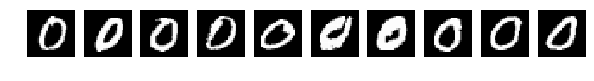

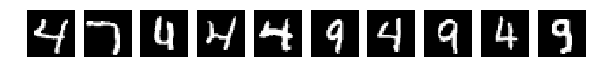

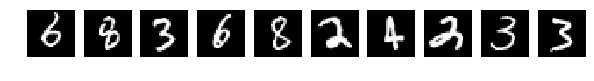

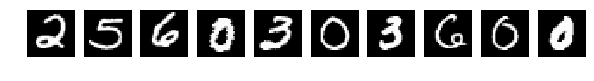

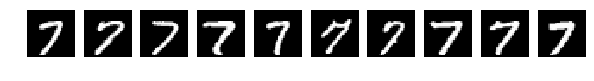

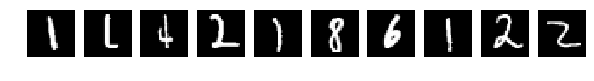

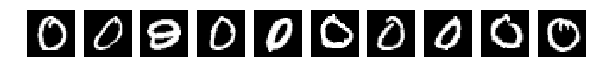

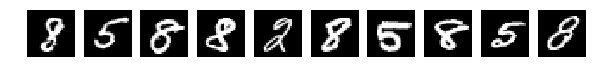

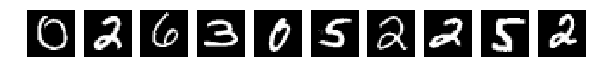

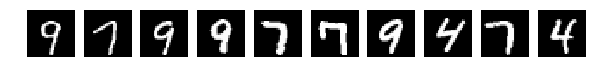

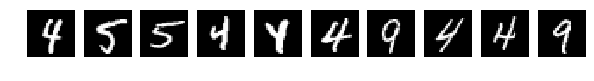

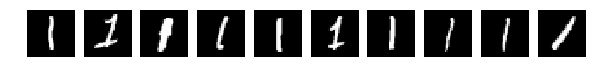

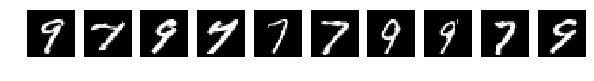

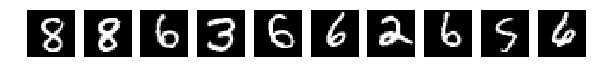

error rate for h = 30, :  0.496


In [25]:
for i in [25, 30]:
    print(i)
    err = select_bandwidth(x_train, y_train, i)
    print('error rate for h = {}, : '.format(i), err)

When h < 20, the kmeans classifier will give very eneven distribution for each class. Hence, I experiement with h = 
20, 25, 30. It can be seen that from the three parameter values, when h = 25 gives the lowest error rate. 

In [26]:
## Part 4: Classification
# a). 
# predict a new data point
def pred(m, v, train_x, train_y, test_x):
    lg = LogisticRegression(fit_intercept=True, C=100000, penalty='l2',
                multi_class='multinomial',solver='lbfgs', max_iter=1000)
    # project x on the subspace spanned by pc
    mean = np.mean(train_x, axis=0)
    pc = np.dot(train_x - mean, v[:m, :].T) 
    model = lg.fit(pc, train_y)
    proj = np.dot(test_x - np.mean(test_x, axis=0), v[:m, :].T)
    pred = model.predict(proj)
    return pred

In [27]:
# this function can be used to select parameter m 
# using x_train (k-fold cross validation will give 
# the average error rate for each m). Since this 
# process is similar to what required in the next 
# steps, I omit the computation here. 
import warnings
warnings.filterwarnings('ignore')
m = 10
def select_m(m, v, x, y):
    kf = KFold(n_splits=10, random_state=0)
    error = []
    for train_index, test_index in kf.split(x):
        X_train, X_test = x[train_index], x[test_index]
        Y_train, Y_test = y[train_index], y[test_index]
        Y_train, Y_test = np.array(Y_train), np.array(Y_test)
        y_pred = pred(X_train, Y_train, m, X_test)
        e = np.mean(y_pred != Y_test)
        error.append(e)
    error = np.mean(np.array(error))    
    return error

In [29]:
# b). 
n = 100
err_rate = np.zeros(100)
for i in range(1, n):
    y_pred = pred(i, v, x_train, y_train, x_dev)
    err_rate[i] = np.mean(y_pred != y_dev)

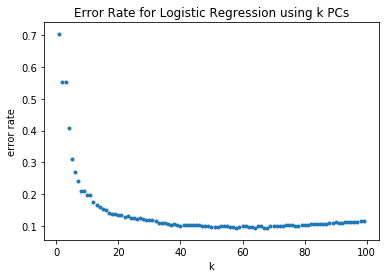

In [30]:
# plot error rate
plt.scatter(range(1, n), err_rate[1:], marker = '.')
plt.title(r'Error Rate for Logistic Regression using k PCs')
plt.xlabel('k')
plt.ylabel('error rate')
plt.show()

In [31]:
print('minimum error rate: ', np.min(err_rate[1:]))
print('k achieves the minimum error rate: ', np.argmin(err_rate[1:]))

minimum error rate:  0.0955
k achieves the minimum error rate:  57


I experimented with the first top 100 principal components, it can be seen that the error rate as a function of k nearly level off when k is greater than 40 (slightly increasing at the right tail). The number of principal components achieve the minimum error rate is 57 (min equals 0.0955). 

In [33]:
# c). retrain the model
x1 = np.vstack((x_train, x_dev))
y1 = np.concatenate((y_train, y_dev), axis=0)
y_pred1 = pred(57, v, x1, y1, x_test)
print('error rate: ', np.mean(y_pred1 != y_test))

error rate:  0.0995


In [34]:
# multinomial logistic regression using raw features
lg = LogisticRegression(fit_intercept=True, C=100000, penalty='l2',
            multi_class='multinomial',solver='lbfgs', max_iter=1000)
model = lg.fit(x1, y1)
pred = model.predict(x_test)
print('error rate: ', np.mean(pred != y_test))

error rate:  0.13


The logistic regression combined with the top k principal components of the best performance works better than the logistic regression using raw features (error rate = 0.0995 vs. 0.13). It suggests that the full model might overfit the data.